In [1011]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [1012]:
titanic_df = pd.read_csv("train.csv")
test_df    = pd.read_csv("test.csv")
te=pd.read_csv("gender_submission.csv")

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1013]:
titanic_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [1014]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId'], axis=1)

In [1015]:
# Ticket

# majority of tickets have their first digit = 1, 2, or 3, which probably also represent different classes. So I just keep the
# first element (a letter or a single-digit number) of these ticket names
titanic_df.Ticket = titanic_df.Ticket.map(lambda x: x[0])
test_df.Ticket = test_df.Ticket.map(lambda x: x[0])

# inspect the correlation between Ticket and Survived
print titanic_df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

   Ticket  Survived
0       1  0.630137
1       2  0.464481
2       3  0.239203
3       4  0.200000
4       5  0.000000
5       6  0.166667
6       7  0.111111
7       8  0.000000
8       9  1.000000
9       A  0.068966
10      C  0.340426
11      F  0.571429
12      L  0.250000
13      P  0.646154
14      S  0.323077
15      W  0.153846


In [1016]:
# inspect the amount of people for each type of tickets
titanic_df['Ticket'].value_counts()

3    301
2    183
1    146
S     65
P     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket, dtype: int64

In [1017]:
# The main categories of Ticket are "1", "2", "3", "P", "S", and "C", so I will combine all the others into "4"
titanic_df['Ticket'] = titanic_df['Ticket'].replace(['A','W','F','L','5','6','7','8','9'], '4')
test_df['Ticket'] = test_df['Ticket'].replace(['A','W','F','L','5','6','7','8','9'], '4')

# dummy encoding
titanic_df = pd.get_dummies(titanic_df,columns=['Ticket'])
test_df = pd.get_dummies(test_df,columns=['Ticket'])

In [1018]:
# Name

titanic_df.Name.head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [1019]:
# extract the titles from the names like Mr where first split by , and take 1 i.e second string then split second string by . 
# and take 0 i.e. first string
titanic_df['Title'] = titanic_df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())
test_df['Title'] = test_df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())

# inspect the amount of people for each title
titanic_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Title, dtype: int64

In [1020]:
# above we can see some have less number so some can be be merged into some of most occured categories. For the rest, 
# store in 'Others'
titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
titanic_df.Title.loc[ (titanic_df.Title !=  'Master') & (titanic_df.Title !=  'Mr') & (titanic_df.Title !=  'Miss') 
                    & (titanic_df.Title !=  'Mrs')] = 'Others'

test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
test_df.Title.loc[ (test_df.Title !=  'Master') & (test_df.Title !=  'Mr') & (test_df.Title !=  'Miss') 
                    & (test_df.Title !=  'Mrs')] = 'Others'

# inspect the correlation between Title and Survived
print titanic_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# drop name
titanic_df = titanic_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

# give number to each category
l1=LabelEncoder()
titanic_df['Title']=l1.fit_transform(titanic_df['Title'])
test_df['Title']=l1.transform(test_df['Title'])

    Title  Survived
0  Master  0.575000
1    Miss  0.701087
2      Mr  0.156673
3     Mrs  0.796875
4  Others  0.318182


In [1021]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# inspect the correlation between Embarked and Survived as well as some other features
print titanic_df[['Embarked', 'Survived','Pclass','Fare', 'Age', 'Sex']].groupby(['Embarked'], as_index=False).mean()

  Embarked  Survived    Pclass       Fare        Age
0        C  0.553571  1.886905  59.954144  30.814769
1        Q  0.389610  2.909091  13.276030  28.089286
2        S  0.339009  2.346749  27.243651  29.519335


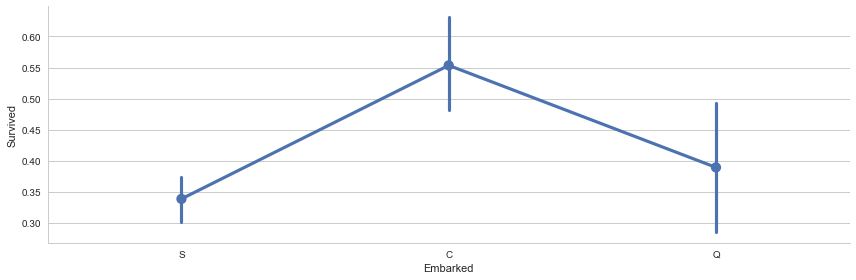

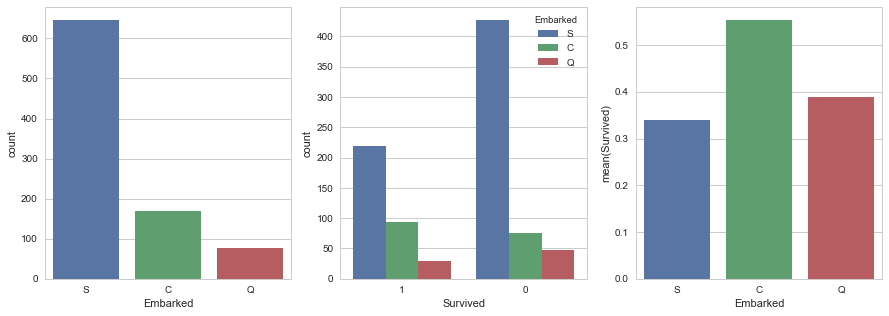

In [1022]:
# plots the point estimate and confidence interval. size is for stretching of plot and aspect for
# stretching of x-axis
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
# counts each category occurance
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
# counts each category occurance according to survival
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)
# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.
# OR
# don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

# get_dummies produces table where each column title is categories in embarked and in table each row 
# tells which category is there in that specific row by putting 0 or 1
#  s1 = ['a', 'b', np.nan]
# get_dummies(s1, dummy_na=True)
#    a  b  NaN
# 0  1  0    0
# 1  0  1    0
# 2  0  0    1

# drop all passengers who have S embarkment
# When inplace=True is passed, the data is renamed in place (it returns nothing)
# When inlace=False is passed (this is the default value, so isn't necessary), 
# performs the operation and returns a copy of the object
embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

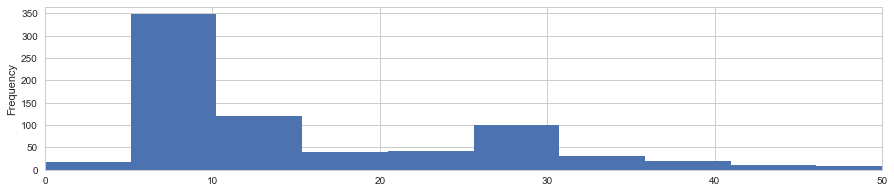

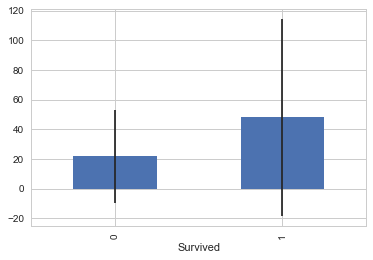

In [1023]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot frequency vs fare
# bins for linespacong, xlim is x-aixs limits
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

In [1024]:
# Divide 'fare' into groups
f = pd.qcut(titanic_df['Fare'], 4)
print (titanic_df.groupby(f).Survived.mean())

Fare
(-0.001, 7.0]    0.215768
(7.0, 14.0]      0.287037
(14.0, 31.0]     0.457399
(31.0, 512.0]    0.597156
Name: Survived, dtype: float64


In [1025]:
# Assign number to fare limits
titanic_df.Fare.loc[ (titanic_df.Fare <= 7) ]= 0
titanic_df.Fare.loc[ (titanic_df.Fare > 7) & (titanic_df.Fare <=  14) ]= 1
titanic_df.Fare.loc[ (titanic_df.Fare > 14) & (titanic_df.Fare <=  31) ]= 2
titanic_df.Fare.loc[ (titanic_df.Fare > 31) ]= 3


test_df.Fare.loc[ (test_df.Fare <= 7) ]= 0
test_df.Fare.loc[ (test_df.Fare > 7) & (test_df.Fare <=  14) ]= 1
test_df.Fare.loc[ (test_df.Fare > 14) & (test_df.Fare <=  31) ]= 2
test_df.Fare.loc[ (test_df.Fare > 31) ]= 3

C:\Users\WIN 8.1\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\WIN 8.1\Anaconda2\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


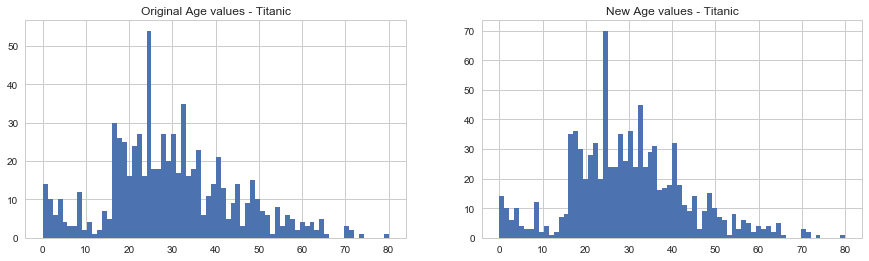

In [1026]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
# get random(from a, to b, n numbers wanted)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)

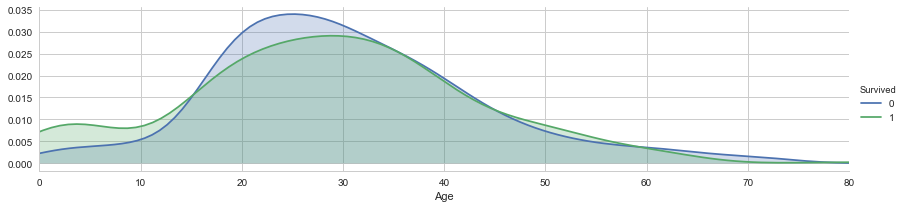

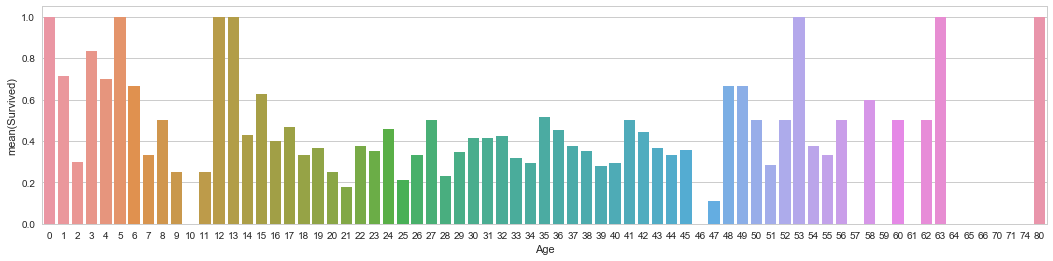

In [1027]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [1028]:
# Divide 'Age' into groups
a = pd.cut(titanic_df['Age'], 5)
print (titanic_df.groupby(a).Survived.mean())

Age
(-0.08, 16.0]    0.547170
(16.0, 32.0]     0.349776
(32.0, 48.0]     0.374517
(48.0, 64.0]     0.434783
(64.0, 80.0]     0.090909
Name: Survived, dtype: float64


In [1029]:
# Assign number to Age limits
titanic_df.Age.loc[ (titanic_df.Age <= 16) ]= 0
titanic_df.Age.loc[ (titanic_df.Age > 16) & (titanic_df.Age <=  32) ]= 1
titanic_df.Age.loc[ (titanic_df.Age > 32) & (titanic_df.Age <=  48) ]= 2
titanic_df.Age.loc[ (titanic_df.Age > 48) & (titanic_df.Age <=  64) ]= 3
titanic_df.Age.loc[ (titanic_df.Age > 64) ]= 4

test_df.Age.loc[ (test_df.Age <= 16) ]= 0
test_df.Age.loc[ (test_df.Age > 16) & (test_df.Age <=  32) ]= 1
test_df.Age.loc[ (test_df.Age > 32) & (test_df.Age <=  48) ]= 2
test_df.Age.loc[ (test_df.Age > 48) & (test_df.Age <=  64) ]= 3
test_df.Age.loc[ (test_df.Age > 64) ]= 4

In [1030]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

In [1031]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"] + 1
# titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
# titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"] + 1

# inspect the correlation between Family and Survived
print titanic_df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

   Family  Survived
0       1  0.303538
1       2  0.552795
2       3  0.578431
3       4  0.724138
4       5  0.200000
5       6  0.136364
6       7  0.333333
7       8  0.000000
8      11  0.000000


In [1032]:
# inspect the amount of people for each Family size
titanic_df['Family'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family, dtype: int64

In [1033]:
# survival rate increases with the family size, but not beyond Family = 4. I will combine all the data with Family > 4 into one
# category i.e Family = 0, such that the survival rate always increases as Family increases.
titanic_df.Family = titanic_df.Family.map(lambda x: 0 if x > 4 else x)
test_df.Family = test_df.Family.map(lambda x: 0 if x > 4 else x)

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

      Sex  Survived
0  female  0.742038
1    male  0.188908


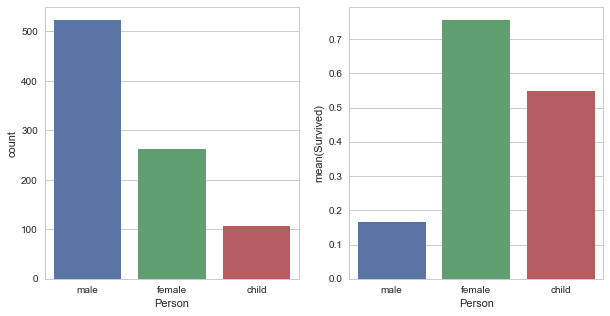

In [1034]:
# Sex

# inspect the correlation between Sex and Survived
print titanic_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

# As we see, children(age < ~16 i.e we assigned it =0) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age ==0 else sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


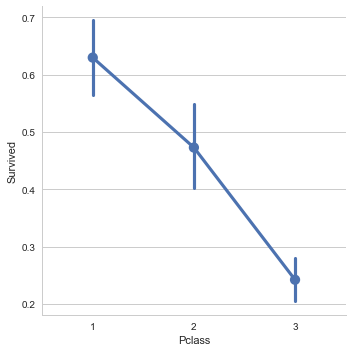

In [1035]:
# Pclass

# get mean of survival for each category in Pclass
# as_index=false is used to display serial number
print titanic_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
# naming each column in pclass_dummies_titanic
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [1036]:
X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [1037]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

0.81930415263748602

In [1038]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Age,-0.287304
1,Fare,-0.194424
2,Ticket_1,0.703076
3,Ticket_2,-0.112765
4,Ticket_3,-0.844965
5,Ticket_4,-1.116282
6,Ticket_C,-0.495913
7,Ticket_P,0.441454
8,Ticket_S,-0.073493
9,Title,-0.207616


In [1039]:
cm=confusion_matrix(te['Survived'],Y_pred)
print cm

[[240  26]
 [ 17 135]]


In [1040]:
# removing features having negative correlation coefficient
#titanic_df = titanic_df.drop(['Ticket_4','Ticket_3','Ticket_C','Title','Age','Fare','Ticket_S','Ticket_2'], axis=1)
#test_df    = test_df.drop(['Ticket_4','Ticket_3','Ticket_C','Title','Age','Fare','Ticket_S','Ticket_2'], axis=1)

#X_train = titanic_df.drop("Survived",axis=1)
#X_test  = test_df.drop("PassengerId",axis=1).copy()

In [1041]:
# Support Vector Machines

svc = SVC()

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)

svc.score(X_train, Y_train)

0.82267115600448937

In [1042]:
cm=confusion_matrix(te['Survived'],Y_pred)
print cm

[[253  13]
 [  8 144]]


In [1043]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)

In [1044]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)

0.856341189674523

In [1045]:
cm=confusion_matrix(te['Survived'],Y_pred)
print cm

[[219  47]
 [ 29 123]]


In [1046]:
# Gaussian Naive Bayes

gaussian = GaussianNB()

gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

gaussian.score(X_train, Y_train)

0.75645342312008979

In [1047]:
cm=confusion_matrix(te['Survived'],Y_pred)
print cm

[[188  78]
 [ 54  98]]


In [1048]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=0)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.90796857463524128

In [1049]:
cm=confusion_matrix(te['Survived'],Y_pred)
print cm

[[229  37]
 [ 28 124]]
